# Exploration

## Char Encoding

In [ ]:
# Vocabulary to encode
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
# Char to num converter
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# Num to char converter
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

### Conversion Test

In [ ]:
# Conversion test
char_to_num(['g', 'a', 'b', 'e'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([7, 1, 2, 5])>

In [ ]:
# Retrieving chars test
num_to_char([7, 1, 2, 5])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'g', b'a', b'b', b'e'], dtype=object)>

## Load Data

### Setup

In [ ]:
# from google.colab import runtime
# runtime.unassign()

In [ ]:
# ! pip list

In [ ]:
# ! pip install imageio opencv-python

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Google path
path = "./drive/MyDrive/Project/Lip_reading/raw_data/"
test_path = "./drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/bbal6n.mpg"
al_path = "./drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1/bbal6n.align"
models_path = "./drive/MyDrive/Project/Lip_reading/models/"


# Local path
# path = "../raw_data/"
# test_path = "../raw_data/videos/s1/bbal6n.mpg"
# al_path = "../raw_data/alignments/s1/bbal6n.align"


Mounted at /content/drive


### Videos

#### Video Loading Test

In [ ]:
# Get the video
explo_test_path = "./drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/bbal6n.mpg"
cap = cv2.VideoCapture(explo_test_path)


array([[[ 88,  65,  56],
        [ 89,  66,  57],
        [106,  64,  58],
        ...,
        [ 55,  30,  21],
        [ 54,  29,  22],
        [ 54,  29,  22]],

       [[212, 189, 180],
        [212, 189, 180],
        [231, 189, 183],
        ...,
        [118,  93,  84],
        [117,  92,  85],
        [117,  92,  85]],

       [[240, 216, 109],
        [241, 217, 110],
        [255, 217, 110],
        ...,
        [129, 111,  40],
        [127, 109,  39],
        [127, 109,  39]],

       ...,

       [[151, 122,  19],
        [151, 122,  19],
        [160, 120,  22],
        ...,
        [102,  83,   4],
        [101,  81,   5],
        [101,  81,   5]],

       [[150, 122,  17],
        [151, 123,  18],
        [160, 121,  20],
        ...,
        [101,  82,   3],
        [101,  81,   5],
        [100,  80,   4]],

       [[150, 122,  17],
        [151, 123,  18],
        [159, 120,  19],
        ...,
        [101,  82,   3],
        [100,  80,   4],
        [100,  80,   4]]], dtype=uint8)
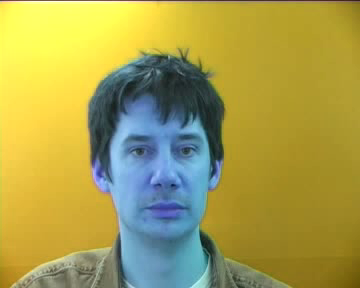

In [ ]:
# Get 1 frame with each iteration
ret, frame = cap.read()
# Display the frame
frame


In [ ]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

array([[146, 146, 147, ..., 121, 120, 117],
       [146, 146, 147, ..., 121, 117, 116],
       [146, 146, 145, ..., 118, 118, 118],
       ...,
       [137, 137, 137, ..., 112, 111, 111],
       [137, 137, 137, ..., 111, 110, 110],
       [137, 137, 137, ..., 111, 110, 110]], dtype=uint8)
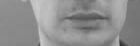

In [ ]:
gray[190:236,80:220]

In [ ]:
gray = tf.image.rgb_to_grayscale(frame)

In [ ]:
# Release the video
cap.release()

#### Video Loading Function

In [ ]:
def load_video(path: str) -> tf.Tensor:
    '''
    Load a video from a path, convert it to grayscale, crop it to the face,
    normalize it with z-score normalization, and return a numpy array of the frames.
    '''
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
      # Get one frame as a numpy array
      ret, frame = cap.read()
      # Grayscale conversion
      #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # => Returns 2D image
      gray = tf.image.rgb_to_grayscale(frame) # => Returns 3D tensor
      # Add the frame to the list
      frames.append(gray[190:236, 80:220, :])
    # Release the video
    cap.release()

    # Normalize the data with z-score normalization
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    return tf.cast((frames - mean), tf.float32) / std


In [ ]:
frames_test = load_video(test_path)

In [ ]:
type(frames_test)

tensorflow.python.framework.ops.EagerTensor

#### Video loading with dlib

In [ ]:
from imutils import face_utils
import dlib
import cv2
import numpy as np
from imutils import face_utils
import os
import glob

# Load dlib model
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./drive/MyDrive/Project/Lip_reading/dlib/shape_predictor_68_face_landmarks.dat")

def extract_lip_region(frame, landmarks):
    # Use a margin of 10
    margin = 10
    # Use the landmarks for the outer lip
    left = landmarks[48][0] - margin
    right = landmarks[54][0] + margin
    top = landmarks[50][1] - margin
    bottom = landmarks[58][1] + margin
    # Ensure the coordinates are within image bounds
    left = max(left, 0)
    right = min(right, frame.shape[1])
    top = max(top, 0)
    bottom = min(bottom, frame.shape[0])
    mouth = frame[top:bottom, left:right]
    mouth_resized = cv2.resize(mouth, (100, 50))  # Resize to a fixed size
    return mouth_resized

def load_video(path: str) -> tf.Tensor:
    '''
    Load a video from a path, convert it to grayscale, crop it to the face,
    normalize it with z-score normalization, and return a numpy array of the frames.
    '''
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
      # Get one frame as a numpy array
      ret, frame = cap.read()
      # Grayscale conversion
      #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # => Returns 2D image

      faces = detector(frame)
      if len(faces) > 0:
          shape = predictor(frame, faces[0])
          shape = face_utils.shape_to_np(shape)
          lip = extract_lip_region(frame, shape)

      gray = tf.image.rgb_to_grayscale(lip) # => Returns 3D tensor
      # Add the frame to the list
      frames.append(gray)
    # Release the video
    cap.release()

    # Normalize the data with z-score normalization
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
path_test5 = "./drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/bbal6n.mpg"

frames = load_video(path_test5)

In [ ]:
frames.shape

TensorShape([75, 50, 100, 1])

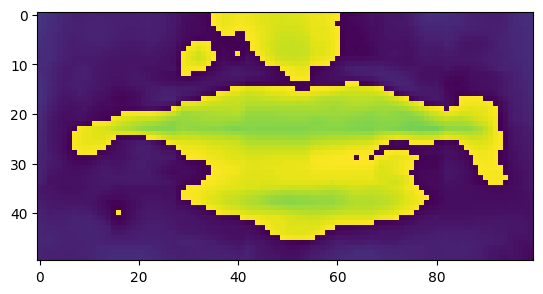

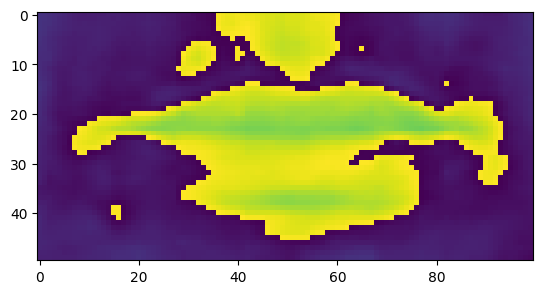

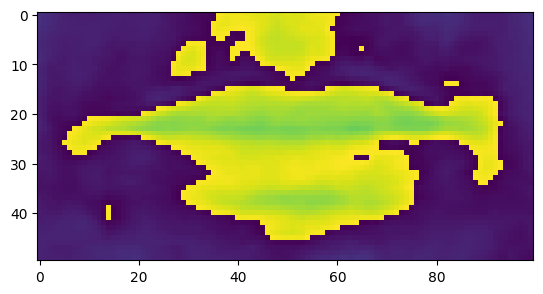

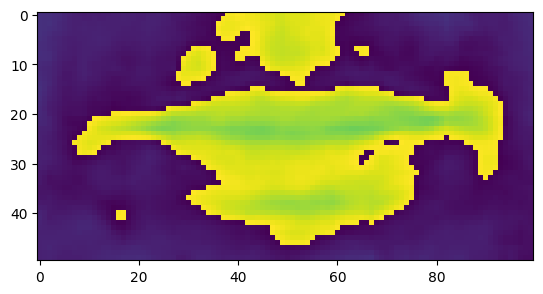

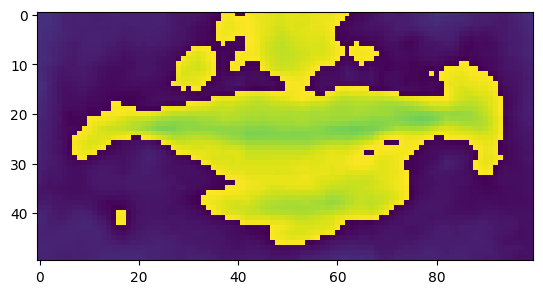

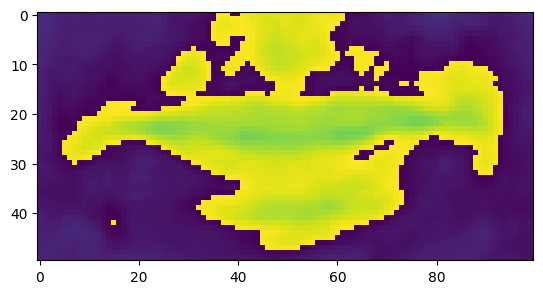

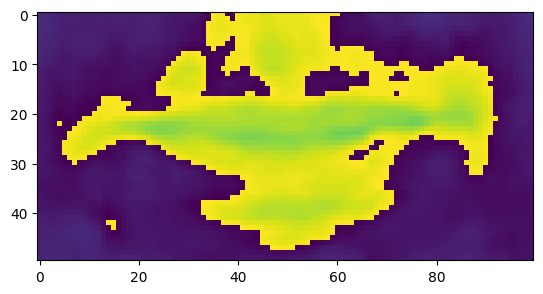

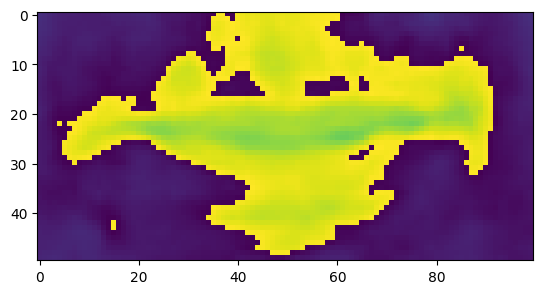

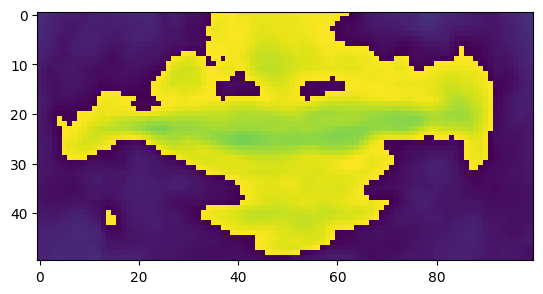

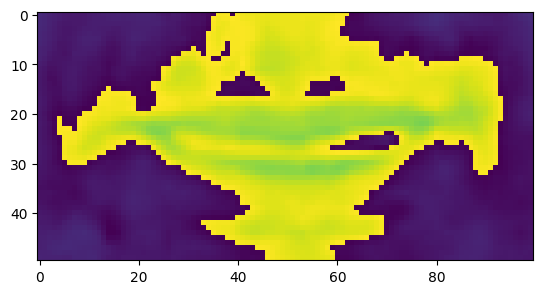

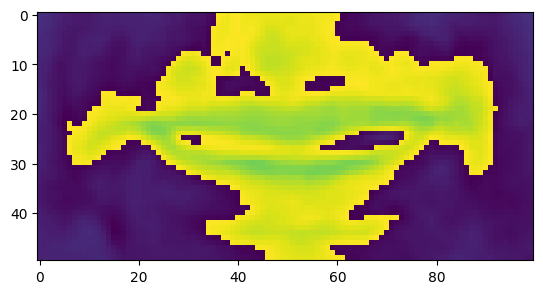

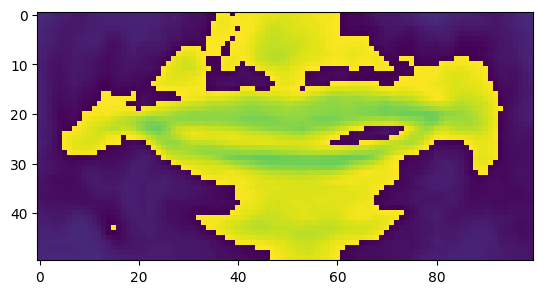

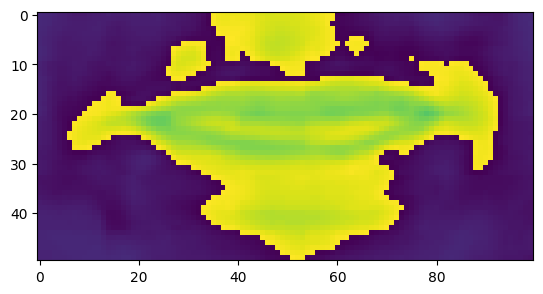

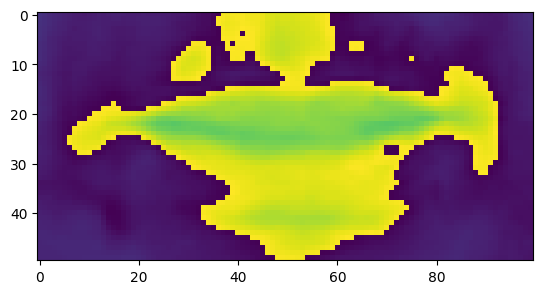

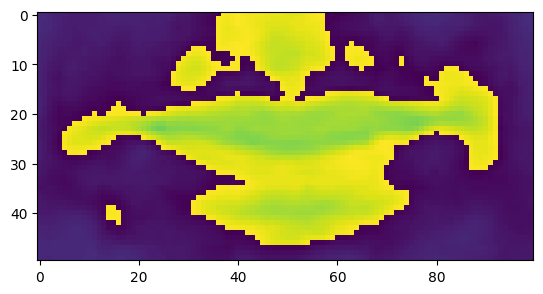

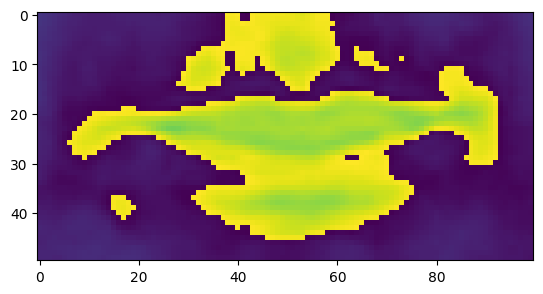

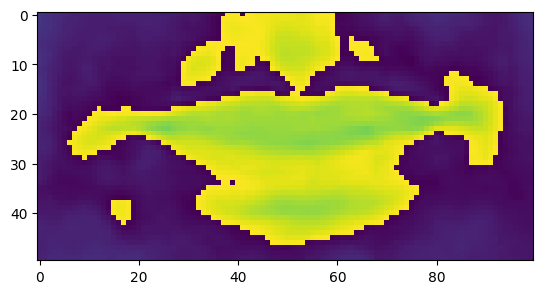

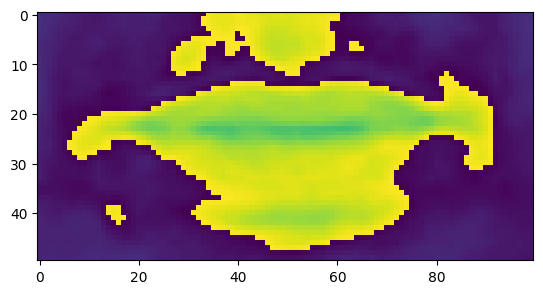

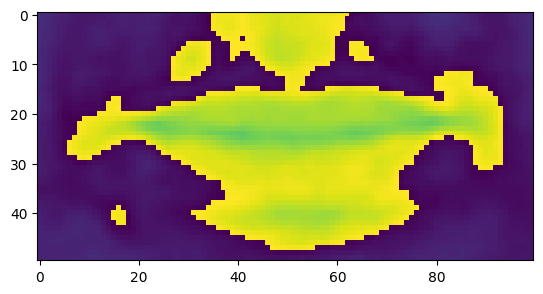

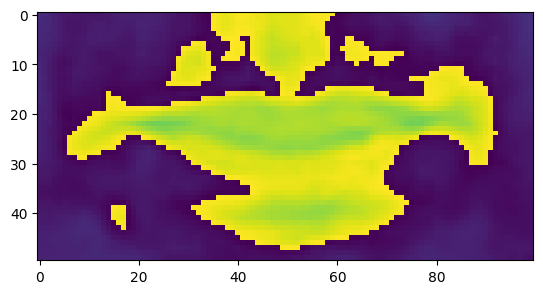

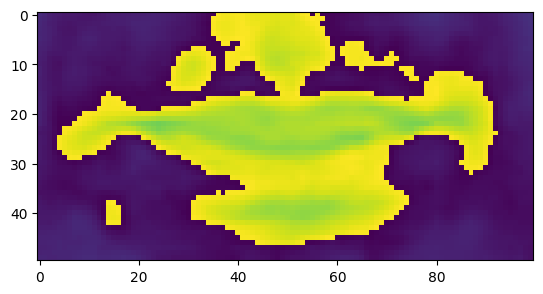

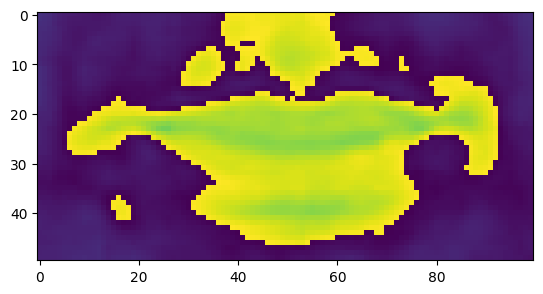

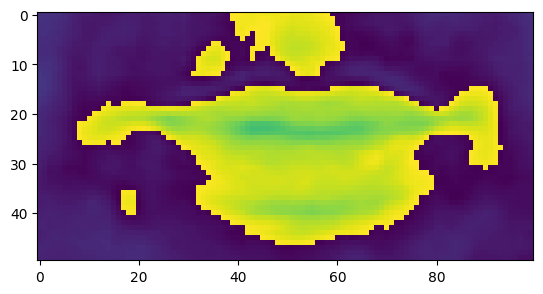

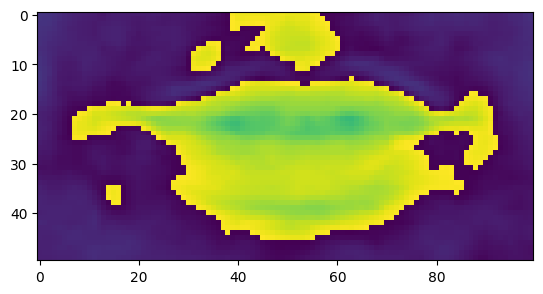

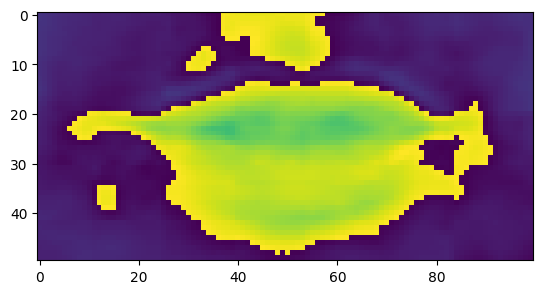

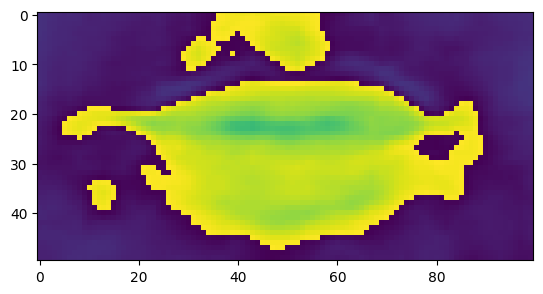

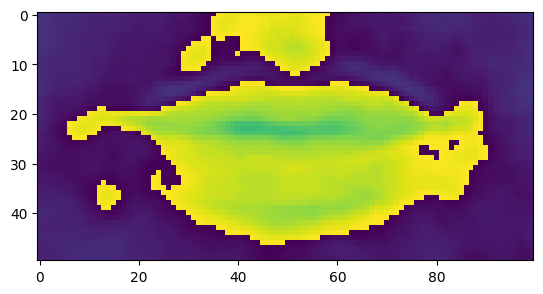

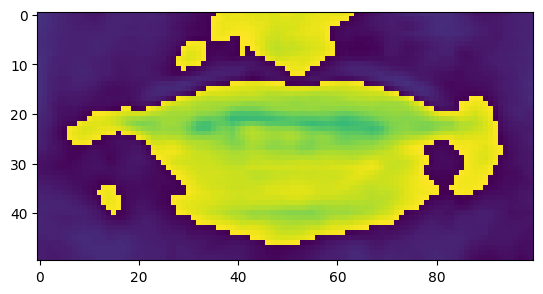

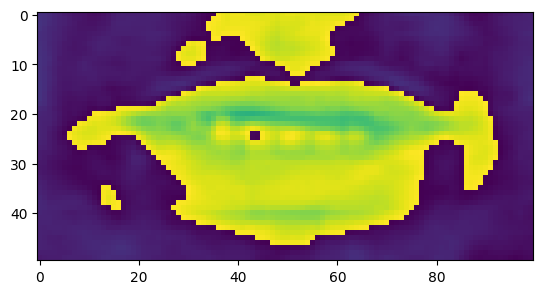

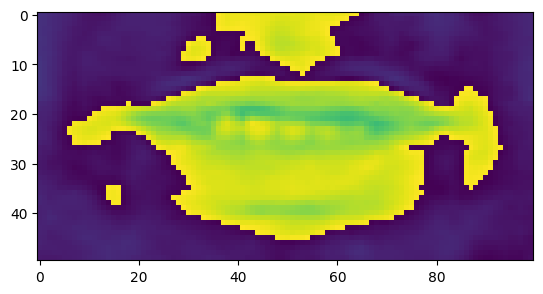

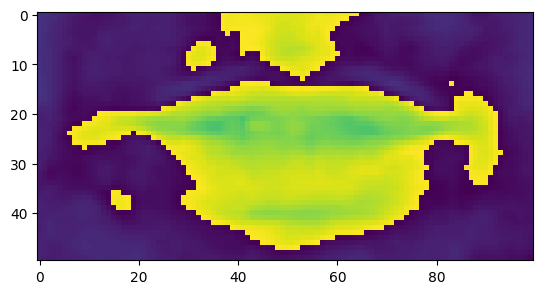

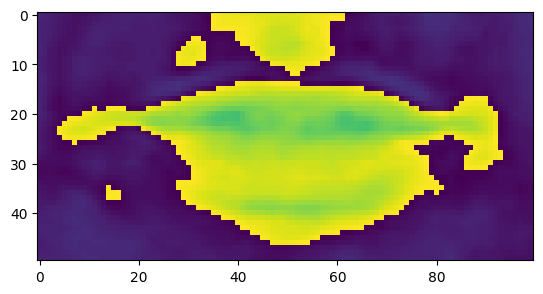

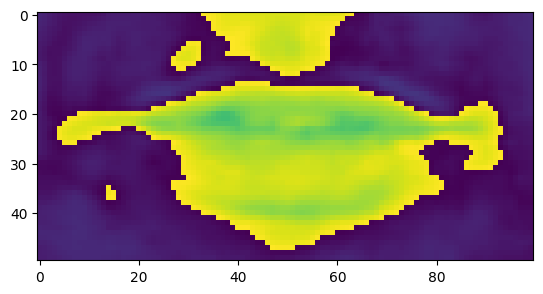

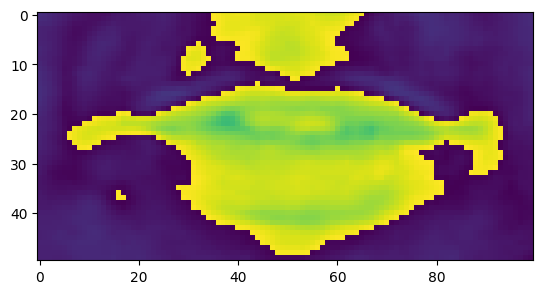

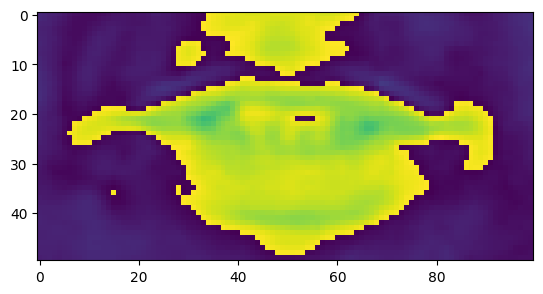

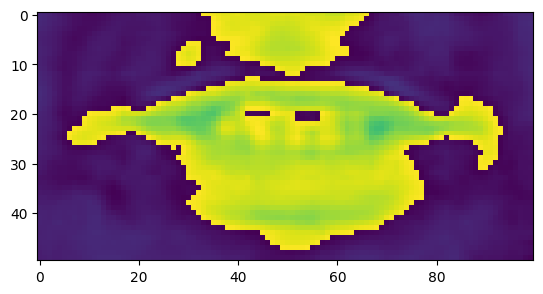

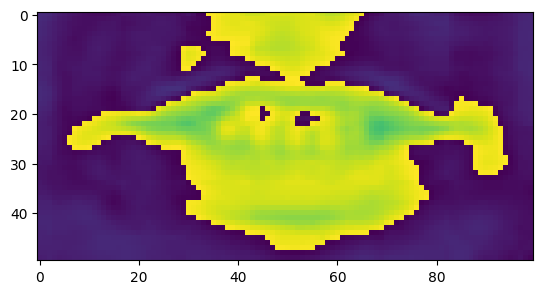

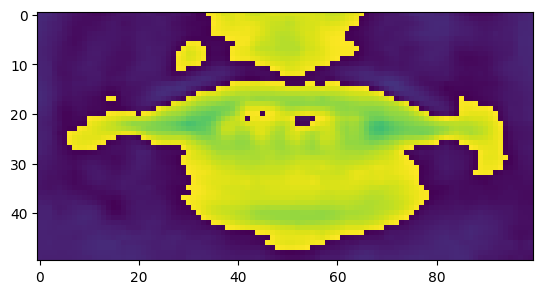

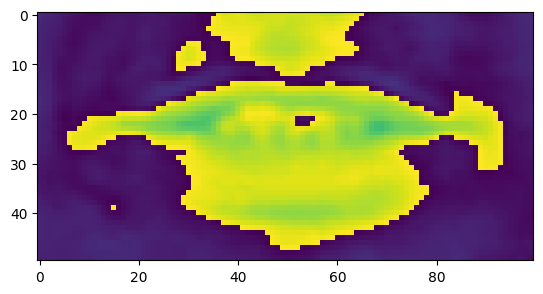

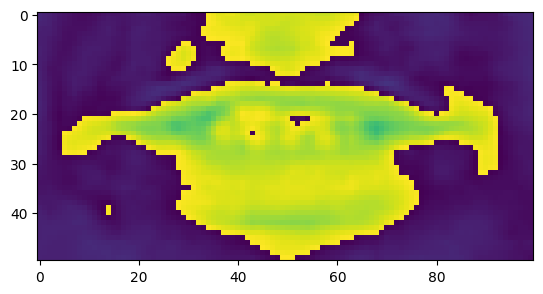

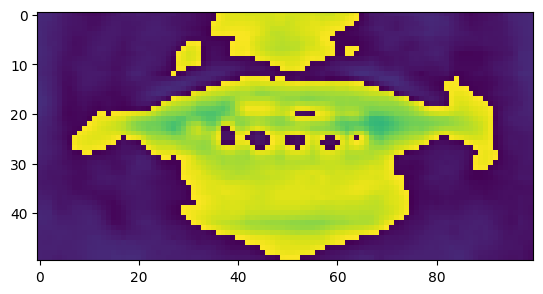

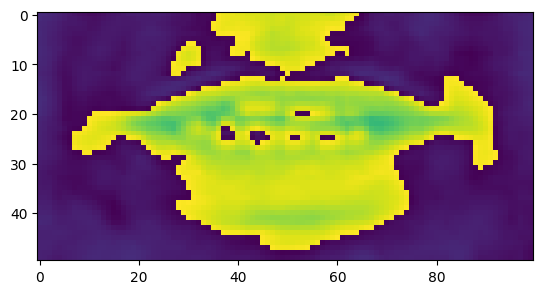

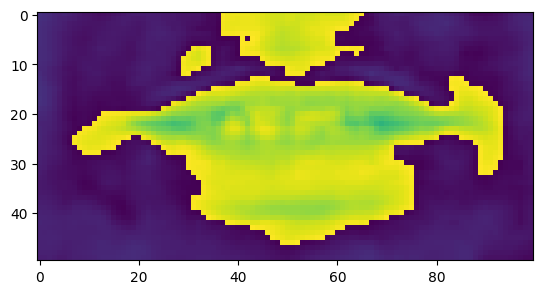

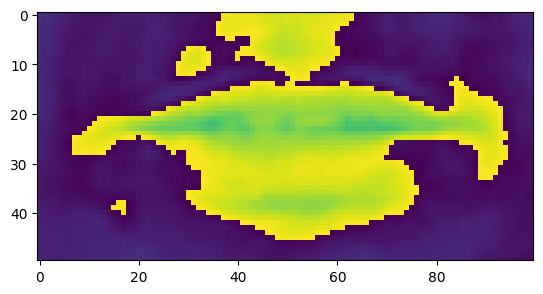

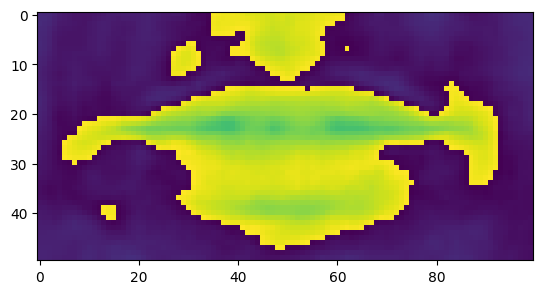

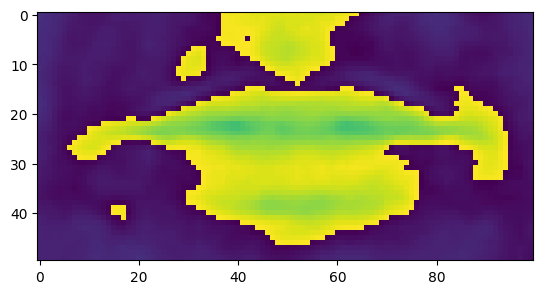

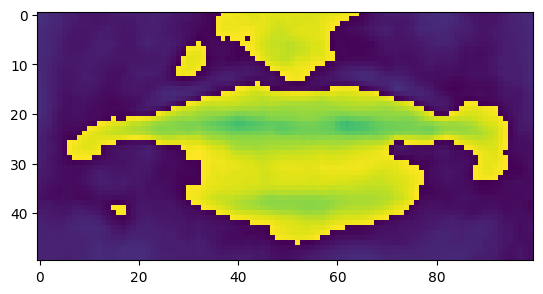

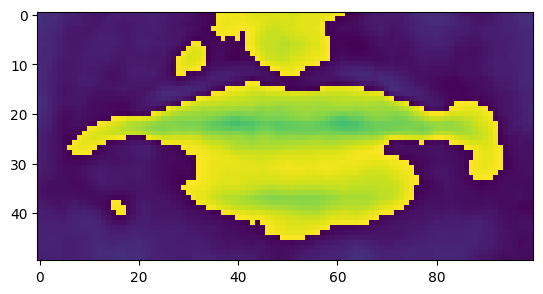

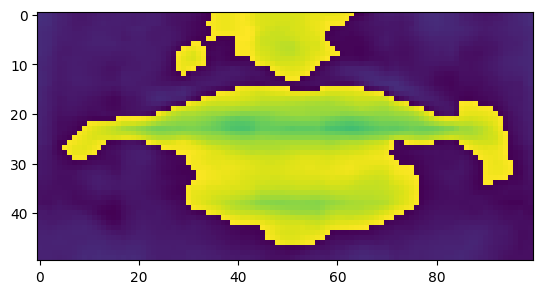

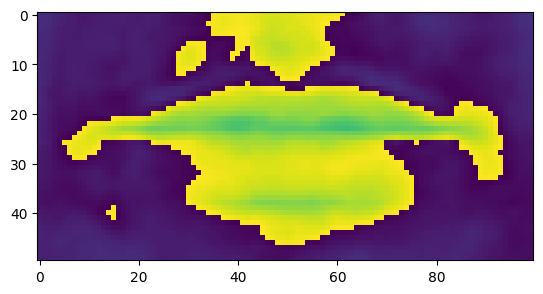

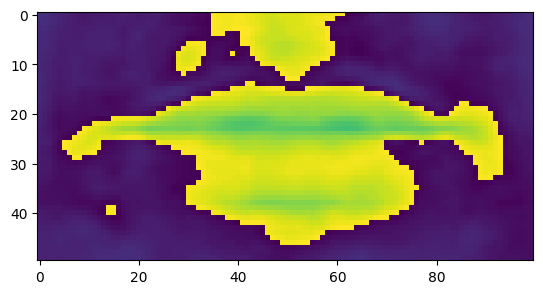

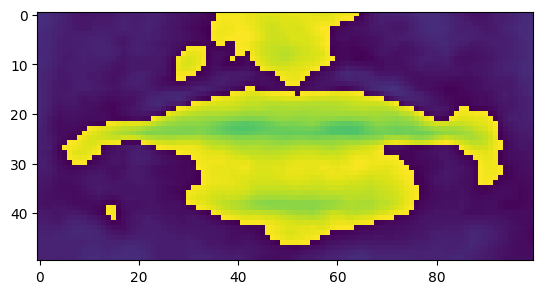

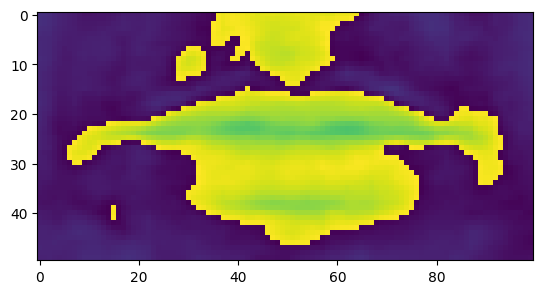

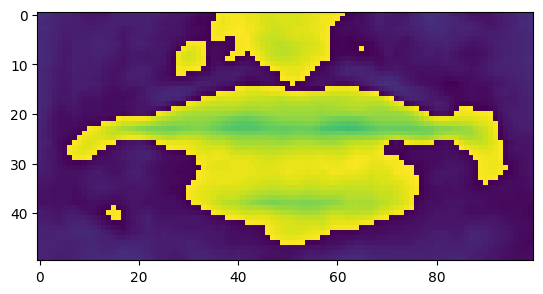

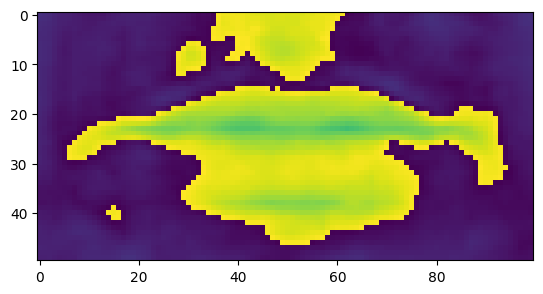

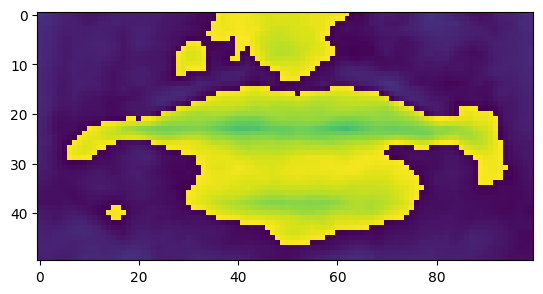

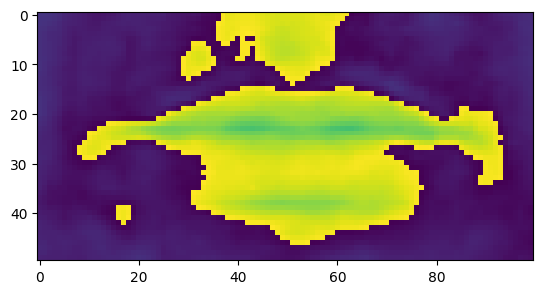

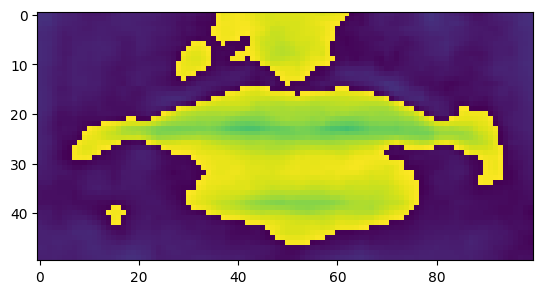

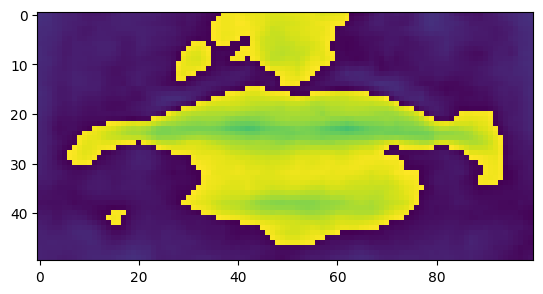

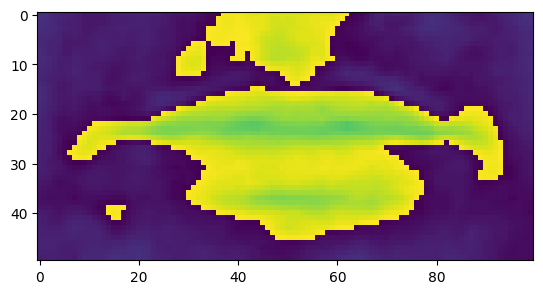

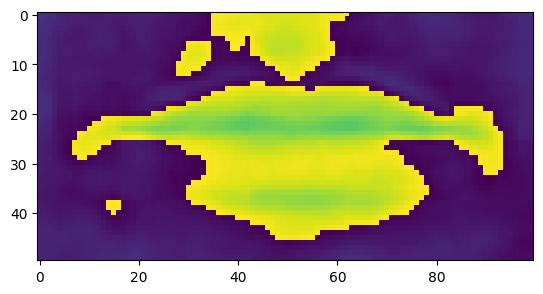

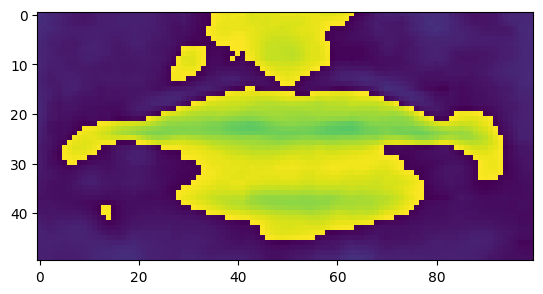

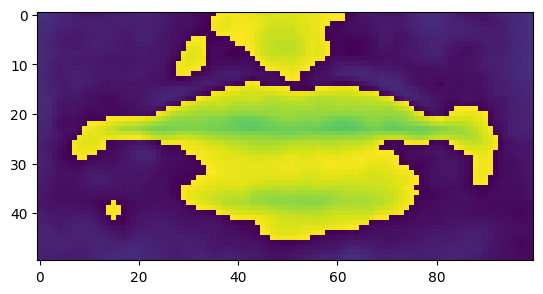

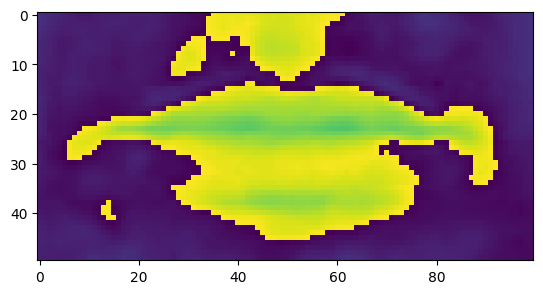

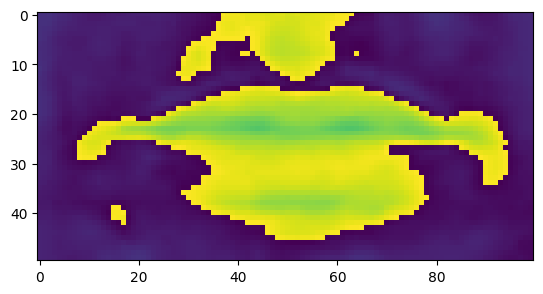

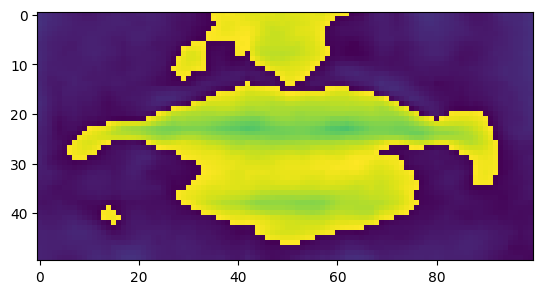

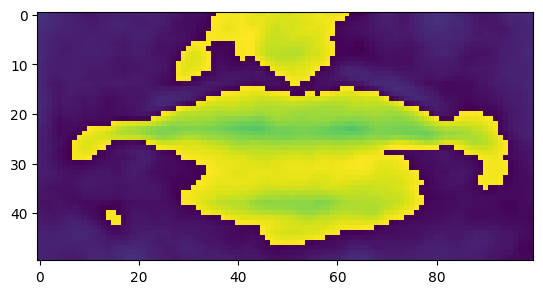

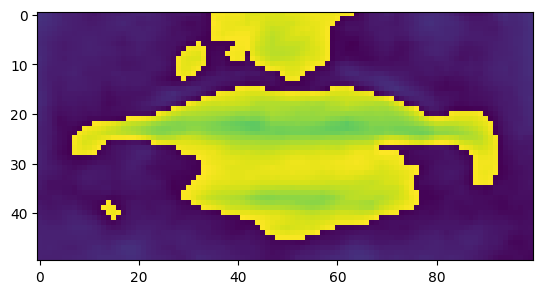

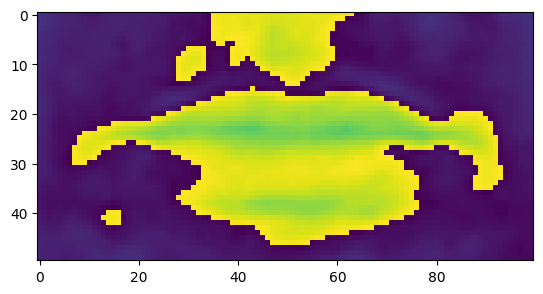

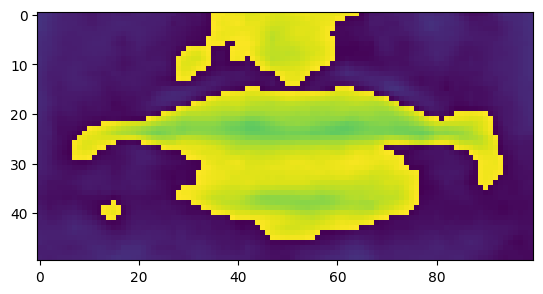

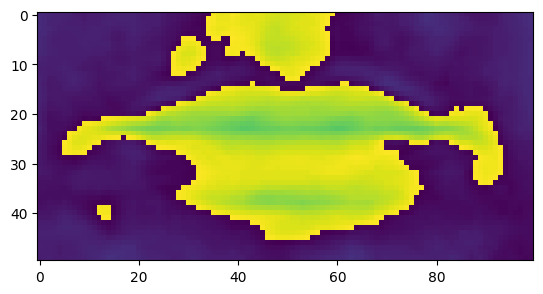

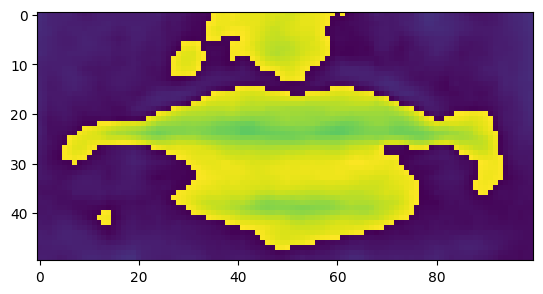

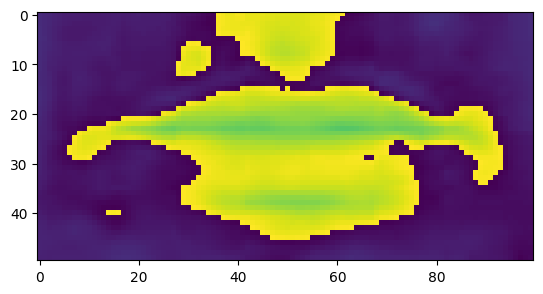

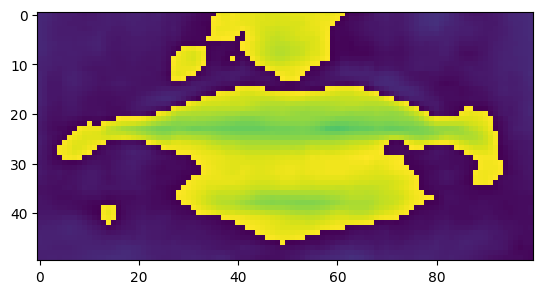

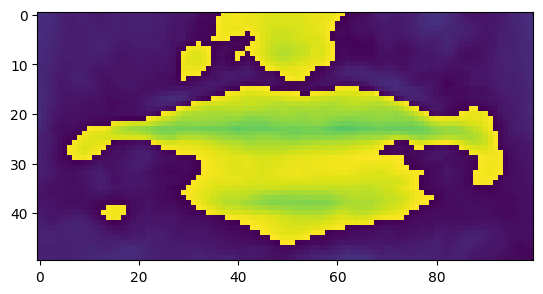

In [ ]:
frames.shape

for frame in frames:
  plt.imshow(tf.squeeze(frame))
  plt.show()

#### Check for corrupted videos

In [ ]:
import cv2

def is_video_corrupted(video_path):
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return True
        ret, frame = cap.read() # Attempt to read a frame
        cap.release()
        return not ret # If no frame was read, it's corrupted
    except cv2.error as e:
        print(f"OpenCV error: {e}")
        return True
    except Exception as e:
        print(f"An error occurred: {e}")
        return True

corrupted_videos = []
videos_path = './drive/MyDrive/Project/Lip_reading/raw_data/videos'

for video in os.listdir(videos_path):
    video_path = os.path.join(videos_path, video)
    if is_video_corrupted(video_path):
        print(f"{video_path} is corrupted.")
        corrupted_videos.append(video_path)
    else:
        print(f"{video_path} is not corrupted.")


Streaming output truncated to the last 5000 lines.
./drive/MyDrive/Project/Lip_reading/raw_data/videos/bbac1p.mpg is not corrupted.
./drive/MyDrive/Project/Lip_reading/raw_data/videos/bbac2a.mpg is not corrupted.
./drive/MyDrive/Project/Lip_reading/raw_data/videos/bbaczs.mpg is not corrupted.
./drive/MyDrive/Project/Lip_reading/raw_data/videos/bbai3n.mpg is not corrupted.
./drive/MyDrive/Project/Lip_reading/raw_data/videos/bbai4s.mpg is not corrupted.
./drive/MyDrive/Project/Lip_reading/raw_data/videos/bbai5p.mpg is not corrupted.
./drive/MyDrive/Project/Lip_reading/raw_data/videos/bbai6a.mpg is not corrupted.
./drive/MyDrive/Project/Lip_reading/raw_data/videos/bbao7n.mpg is not corrupted.
./drive/MyDrive/Project/Lip_reading/raw_data/videos/bbao8s.mpg is not corrupted.
./drive/MyDrive/Project/Lip_reading/raw_data/videos/bbao9p.mpg is not corrupted.
./drive/MyDrive/Project/Lip_reading/raw_data/videos/bbapza.mpg is not corrupted.
./drive/MyDrive/Project/Lip_reading/raw_data/videos/bbav1n

In [ ]:
corrupted_videos

['./drive/MyDrive/Project/Lip_reading/raw_data/videos/bgbz7n.mpg',
 './drive/MyDrive/Project/Lip_reading/raw_data/videos/swag2s.mpg']

In [ ]:
corrupted_videos

['./drive/MyDrive/Project/Lip_reading/raw_data/videos/pwbo7p.mpg',
 './drive/MyDrive/Project/Lip_reading/raw_data/videos/corrupted']

### Alignments

#### Alignments Loading Test

In [ ]:
# Open align file
with open(al_path, "r") as f:
    lines = f.readlines()

In [ ]:
lines

['0 16000 sil\n',
 '16000 21250 bin\n',
 '21250 26750 blue\n',
 '26750 27750 at\n',
 '27750 31500 l\n',
 '31500 39250 six\n',
 '39250 45250 now\n',
 '45250 74500 sil\n']

In [ ]:
# Tokienize alignments
tokens = []
for line in lines:
    line = line.split()
    # Ignore silence tokens
    if line[2] != "sil":
        tokens = [*tokens, ' ', line[2]]

tokens

[' ', 'bin', ' ', 'blue', ' ', 'at', ' ', 'l', ' ', 'six', ' ', 'now']

#### Alignments Loading Function

In [ ]:
def load_alignments(path: str) -> tf.Tensor:
  '''
  Load alignments from a path, tokenize them,
  and return the encoded characters as a 1D tensor.
  '''
  # Open align file
  with open(path, "r") as f:
    lines = f.readlines()

  # Tokenize alignments
  tokens = []
  for line in lines:
      line = line.split()
      # Ignore silence tokens
      if line[2] != "sil":
          tokens = [*tokens, ' ', line[2]]

  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

#### Test

In [ ]:
x = load_alignments(al_path)
x

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
num_to_char(x)

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'b', b'i', b'n', b' ', b'b', b'l', b'u', b'e', b' ', b'a', b't',
       b' ', b'l', b' ', b's', b'i', b'x', b' ', b'n', b'o', b'w'],
      dtype=object)>

In [ ]:
path_2 = "./drive/MyDrive/Project/Lip_reading/raw_data/alignments/s1"
# path_2 = "../raw_data/alignments/s1"


alignments = []

for file in os.listdir(path_2):
  alignment = load_alignments(os.path.join(path_2, file))
  alignments.append(alignment)
  print(f"Loaded {file}")

In [ ]:
tf.convert_to_tensor(path).numpy().decode('utf-8')

### Data

#### Load Data Function

In [ ]:
def load_data(path: tf.Tensor):
  '''
  Take a path as a tensor, load the video and corresponding alignments,
  and return two tensors, one for the processed frames,
  one for the encoded tokens.
  '''
  # Convert the path back into a string
  path = bytes.decode(path.numpy())

  # Get file name from path
  file_name = path.split('/')[-1].split('.')[0]

  # Get path from file name
  # video_path = os.path.join('../raw_data/videos/s1',f'{file_name}.mpg')
  # alignment_path = os.path.join('../raw_data/alignments/s1',f'{file_name}.align')

   # Get path from file name
  video_path = os.path.join('./drive/MyDrive/Project/Lip_reading/raw_data//videos/s1',f'{file_name}.mpg')
  alignment_path = os.path.join('./drive/MyDrive/Project/Lip_reading/raw_data//alignments/s1',f'{file_name}.align')

  # Load data
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)

  return frames, alignments

#### Load Test

In [ ]:
path_3 = "./drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/bbaf2n.mpg"
path_3 = tf.convert_to_tensor(path_3)
f, a = load_data(path_3)

In [ ]:
plt.imshow(f[0])

In [ ]:
a

## Pipeline

In [ ]:
def map_function(path):
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [ ]:
data = tf.data.Dataset.list_files(
    './drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/*.mpg'
    # '../raw_data/videos/s1/*.mpg'
)
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(map_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Train Test Split
train = data.take(450)
test = data.skip(450)

In [ ]:
len(train), len(test)

(450, 50)

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
frames.shape

(2, 75, 46, 140, 1)

## DNN

In [ ]:
# Initialize
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,50,100,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Reshape((-1,))))
# model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

## Baseline Prediction

Done without training, on a manual cropped frame

In [ ]:
sample = data.as_numpy_iterator()


In [ ]:
# val is a tuple of a batch of 2 videos,
# and a batch of the 2 alignments corresponding to those videos
# val[0]: videos, val[1]: y_true
# val[0][0]: first video, val[1][0]: first y_true
val = sample.next(); val[0]


array([[[[[1.3280903 ],
          [1.3280903 ],
          [1.3280903 ],
          ...,
          [0.07589088],
          [0.18972719],
          [0.11383631]],

         [[1.3280903 ],
          [1.3280903 ],
          [1.3280903 ],
          ...,
          [0.03794544],
          [0.15178175],
          [0.15178175]],

         [[1.3280903 ],
          [1.3280903 ],
          [1.3280903 ],
          ...,
          [0.07589088],
          [0.11383631],
          [0.11383631]],

         ...,

         [[0.9865813 ],
          [0.9865813 ],
          [0.9865813 ],
          ...,
          [9.56225   ],
          [9.48636   ],
          [9.48636   ]],

         [[0.94863594],
          [0.94863594],
          [0.94863594],
          ...,
          [9.524304  ],
          [9.48636   ],
          [9.48636   ]],

         [[0.94863594],
          [0.94863594],
          [0.94863594],
          ...,
          [9.524304  ],
          [9.48636   ],
          [9.48636   ]]],


        [[[1.3660

In [ ]:
val[0].shape

(2, 75, 46, 140, 1)

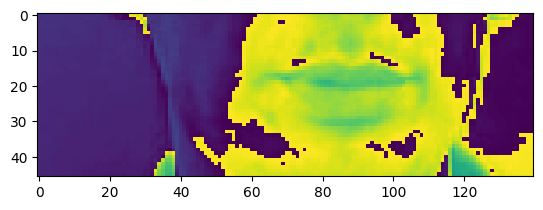

In [ ]:
# 0:videos, 0: 1st video out of the batch,  20: return the 20th frame in the video
plt.imshow(val[0][0][20])


In [ ]:
# Convert back into string the y_true for the first video
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in x four now'>

In [ ]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [ ]:
# Displaying the baseline prediction
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzww'>

## Setup Training

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
# Source https://keras.io/examples/audio/ctc_asr/
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join(models_path,'checkpoint_epoch{epoch:02d}_loss{loss:.2f}.weights.h5'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

# Pipeline

## Setup

In [2]:
# Imports
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
from imutils import face_utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


2025-06-03 11:48:40.353582: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 11:48:40.523040: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-03 11:48:40.683203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748918920.810169   19279 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748918920.846985   19279 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748918921.134442   19279 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [6]:
# Check if running of Google Colab
def is_running_on_colab():
    try:
        if 'google.colab' in str(get_ipython()):
            return True
        else:
            return False
    except NameError:
        return False

if is_running_on_colab():
    print("Running on Google Colab")

    # Check for available GPUs and, if found, configure TensorFlow to use memory growth
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        # Ensure at least one GPU is available
        if physical_devices:
            tf.config.experimental.set_memory_growth(physical_devices[0], True)
            print("GPU memory growth enabled.")
        else:
            print("No GPU devices found.")
    except:
        print(f"Error setting GPU memory growth: {e}")
        pass

    # Get GPU infos
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)

    # Connect to Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Setup the Google root
    root_path = "./drive/MyDrive/Project/Lip_reading"
else:
    print("Running on a local machine")
    # Setup the local root
    root_path = ".."

# Displays the number of avaible GPUs
print("\nNum GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set the main data directories
data_path = 'raw_data'
# Set the data sub-directories
videos_path = os.path.join(root_path, data_path, 'videos')
aligns_path = os.path.join(root_path, data_path, 'alignments')
models_path = os.path.join(root_path, 'models')
dlib_path = os.path.join(root_path, 'dlib')


Running on a local machine

Num GPUs Available:  0


In [7]:
import dlib # DO NOT IMPORT BEFORE TENSORFLOW => Will create conflicts

## Functions

In [21]:
# Encoder
# Vocabulary to encode
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

# Char to num converter
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# Num to char converter
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

# Load dlib model
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(os.path.join(dlib_path, "shape_predictor_68_face_landmarks.dat"))


# ---------------------------------------------------------------
# Data loader

def extract_lip_region(frame, landmarks):
    '''
    Get a frame and exctract the lips area.
    '''
    # Use a margin of 10
    margin = 10
    # Use the landmarks for the outer lip
    left = landmarks[48][0] - margin
    right = landmarks[54][0] + margin
    top = landmarks[50][1] - margin
    bottom = landmarks[58][1] + margin
    # Ensure the coordinates are within image bounds
    left = max(left, 0)
    right = min(right, frame.shape[1])
    top = max(top, 0)
    bottom = min(bottom, frame.shape[0])
    mouth = frame[top:bottom, left:right]
    if mouth.size == 0:
        # Return a small placeholder or handle as an error
        # Returning a small dummy array might prevent errors later, but might not be ideal for training
        print("Warning: Extracted lip region is empty.")
        return np.zeros((50, 100, frame.shape[-1]), dtype=frame.dtype) # Assuming original frame might be color

    mouth_resized = cv2.resize(mouth, (100, 50))  # Resize to a fixed size
    return mouth_resized

def load_video(path: str) -> tf.Tensor:
    '''
    Load a video from a path, extract the lips with dlib, or use the previous successful frame.
    If no previous successful frame is available and detection fails, the frame is skipped.
    Convert to grayscale, normalize with z-score normalization, and return a numpy array of frames.
    '''
    cap = cv2.VideoCapture(path)
    frames = []
    last_successful_frame = None  # Keep track of the last successfully extracted grayscale lip frame

    # Check if video capture is successful
    if not cap.isOpened():
        print(f"Error: Could not open video file {path}")
        # Return an empty tensor or handle the error appropriately
        return tf.zeros([0, 50, 100, 1], dtype=tf.float32)

    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        # Read the next frame
        ret, frame = cap.read()
        if not ret: # Check if frame was read successfully
            continue # Skip if frame reading failed
        # Extract the face with dlib
        face = detector(frame)

        if len(face) > 0: # If a face has been detected
            shape = predictor(frame, face[0])
            shape = face_utils.shape_to_np(shape)
            lip = extract_lip_region(frame, shape)

            # Ensure the extracted lip region is not empty before processing
            if lip.size > 0:
                # Grayscale conversion
                gray = tf.image.rgb_to_grayscale(lip)
                # Save the frame
                frames.append(gray)
                last_successful_frame = gray # Update the last successful frame
            else:
                # If extraction failed even with a detected face, try using the previous successful frame
                if last_successful_frame is not None:
                    frames.append(last_successful_frame)
                # Else: If no previous successful frame, the frame is skipped implicitly (not appended)

        else: # No face detected
            # If no previous successful frame is available, the frame is skipped implicitly (not appended)
            if last_successful_frame is not None:
                 # Use the last successful frame as a placeholder if available
                frames.append(last_successful_frame)
            # Else: If no previous successful frame, the frame is skipped implicitly (not appended)


    cap.release()

    # Handle the case where no frames were processed
    if not frames:
        # Return an empty tensor
        empty_frame_shape = (50, 100, 1)
        return tf.zeros([0] + list(empty_frame_shape), dtype=tf.float32)

    # Normalize the data with z-score normalization
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    # Add a small epsilon to std to avoid division by zero
    std = tf.maximum(std, tf.keras.backend.epsilon())


    return tf.cast((frames - mean), tf.float32) / std

def load_alignments(path: str) -> tf.Tensor:
  '''
  Load alignments from a path, tokenize them,
  and return the encoded characters as a 1D tensor.
  '''
  # Open align file
  with open(path, "r") as f:
    lines = f.readlines()

  # Tokenize alignments
  tokens = []
  for line in lines:
      line = line.split()
      # Ignore silence tokens
      if line[2] != "sil":
          tokens = [*tokens, ' ', line[2]]

  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

def load_data(path: tf.Tensor):
  '''
  Take a path as a tensor, load the video and corresponding alignments,
  and return two tensors, one for the processed frames,
  one for the encoded tokens.

  The path must end by /video/ or /alignment/, the speaker folder, and the name of the file.
  '''
  # Convert the path back into a string
  path = bytes.decode(path.numpy())

  path_components = path.split('/')
  # Get file and folder name from path

  file_name_with_extension = path_components[-1]
  file_name = file_name_with_extension.split('.')[0]

  path_without_folder_and_file = '/'.join(path_components[:-2])

   # Get path from file name
  video_path = os.path.join(path_without_folder_and_file, 'videos', f'{file_name}.mpg')
  alignment_path = os.path.join(path_without_folder_and_file, 'alignments', f'{file_name}.align')

  # Load data
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)

  return frames, alignments



# ---------------------------------------------------------------
# Data Preprocessing
# Create map function from load_data()
def map_function(path):
    '''
    Wrapper function for load_data()
    '''
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

def preprocess_training_data(path: str, train_samples_to_keep=0.9):
    '''
    Takes the path to the data folder as a string,
    preprocess the videos from that path into batches of 2,
    and return training and testing sets.
    '''
    batch_size = 6

    data = tf.data.Dataset.list_files(
        f'{path}/*.mpg'
    )
    total_num_videos = len(list(data.as_numpy_iterator()))

    data = data.shuffle(total_num_videos, reshuffle_each_iteration=True)

    # Load and preprocess
    data = data.map(map_function)
    data = data.padded_batch(batch_size, padded_shapes=([75, None, None, None], [40]))
    data = data.prefetch(tf.data.AUTOTUNE)
    # Train Test Split
    train_samples = int((total_num_videos/batch_size) * train_samples_to_keep)
    train = data.take(train_samples)
    test = data.skip(train_samples)

    return train, test

# Video preprocessing
def preprocess_video(path: str):
    '''
    Convert a video from a path into a tensor ready for prediction.
    '''
    video_tensor = tf.convert_to_tensor(path)
    processed_video, processed_align = map_function(video_tensor)
    processed_video = tf.expand_dims(processed_video, axis=0)
    return processed_video, processed_align



# ---------------------------------------------------------------
# Model building
def initialize_model():
    '''
    Initialize the model and return it.
    '''
    input_video_shape = (75, 50, 100, 1)

    model = Sequential()

    model.add(Input(shape=input_video_shape))

    model.add(Conv3D(128, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(Conv3D(256, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(Conv3D(75, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(TimeDistributed(Reshape((-1,))))
    # model.add(TimeDistributed(Flatten())) <= Did not work with this line

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(.5))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(.5))

    model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

    return model

def load_model_weights(model, path: str):
    '''
    Takes a model and a path to a weights.h5 file, loads the weights and return the model.
    '''
    model.load_weights(path)
    return model



# ---------------------------------------------------------------
# Training Setup
def scheduler(epoch, lr):
    '''
    Learning rate scheduler.
    '''
    if epoch < 30:
        return lr
    else:
        return (lr * tf.math.exp(-0.1)).numpy()

# Source https://keras.io/examples/audio/ctc_asr/
def CTCLoss(y_true, y_pred):
    '''
    Calculate the CTC loss between the true and predicted alignments.
    '''
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

class ProduceExample(tf.keras.callbacks.Callback):
    '''
    Callback to display the original and predicted alignments after each epoch.
    '''
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        '''
        Displays the original and predicted alignments after each epoch.
        '''
        data = self.dataset.next()
        yhat = self.model.predict(data[0])

        input_lengths = [tf.shape(yhat)[1].numpy()] * tf.shape(yhat)[0].numpy()

        decoded = tf.keras.backend.ctc_decode(yhat, input_lengths, greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

def compile_model(model):
    adam = Adam(learning_rate=0.0003)
    model.compile(optimizer=adam, loss=CTCLoss)
    return model



# ---------------------------------------------------------------
# Decoding and prediction
def decode_prediction(prediction: tf.Tensor):
    '''
    Takes the prediction and decode it with TensorFlow's ctc_decode
    '''
    decoded_tensor, _ = tf.keras.backend.ctc_decode(prediction, [75], greedy=True)
    decoded_sequence = decoded_tensor[0][0].numpy()
    decoded_text = tf.strings.reduce_join([num_to_char(i) for i in decoded_sequence])
    return decoded_text

def run_prediction(model, path: str):
    '''
    Takes a model and a path to a video and return the prediction as a string.
    '''
    # Preprocessing
    processed_video, processed_align = preprocess_video(path)
    # Prediction
    prediction = model(processed_video)
    # Decoding
    decoded_text = decode_prediction(prediction)
    decoded_text = decoded_text.numpy().decode()

    decoded_align = tf.strings.reduce_join([num_to_char(i) for i in processed_align])
    decoded_align = decoded_align.numpy().decode()

    return decoded_text, decoded_align


# Training

In [ ]:
# Train Test Split
train, test = preprocess_training_data(videos_path)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    os.path.join(
        models_path,
        'checkpoint_epoch{epoch:02d}_loss{loss:.2f}.weights.h5'),
    monitor='loss',
    save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [ ]:
# Check for batches' size
print(f'train: {len(train)}')
print(f'test: {len(test)}')

In [ ]:
# Check for input shape
# Should be (6, 75, 50, 100, 1) in this configuration
# 6: batch size, 75: number of frames, 50: frame height, 100: frame width, 1: channels)
for x, y in train.take(1):
    print(x.shape)

In [ ]:
model = initialize_model()
model = compile_model(model)

model.fit(
    train,
    validation_data=test,
    epochs=50,
    callbacks=[checkpoint_callback, schedule_callback, example_callback]
)

# Prediction Test

## Weights loading

In [9]:
# Weights to load
weights_file_name = 'checkpoint_epoch04_loss52.54.weights.h5'

weights_path = os.path.join(models_path, weights_file_name)
print(f'Loading weights from {weights_path}')

model = initialize_model()
model = load_model_weights(model, weights_path)

Loading weights from ../models/checkpoint_epoch04_loss52.54.weights.h5


## Run Prediction

In [16]:
test_file = "pbwp9a"

test_video_path = os.path.join(videos_path, f'{test_file}.mpg')
test_align_path = os.path.join(aligns_path, f'{test_file}.align')

In [17]:
%%time
pred, align = run_prediction(model, test_video_path)
print(f'Prediction: {pred}')
print(f'Origin:     {align}')

2025-06-03 11:57:21.208482: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 192000000 exceeds 10% of free system memory.
2025-06-03 11:57:21.538108: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 192000000 exceeds 10% of free system memory.
2025-06-03 11:57:24.198164: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 192000000 exceeds 10% of free system memory.
2025-06-03 11:57:26.261932: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48000000 exceeds 10% of free system memory.
2025-06-03 11:57:27.417219: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 96000000 exceeds 10% of free system memory.


Prediction: pla re ee oon
Origin:     place blue with p nine again
CPU times: user 33.1 s, sys: 40.7 s, total: 1min 13s
Wall time: 18.2 s


# Evaluation

In [ ]:
# ! pip install jiwer

In [ ]:
train, test = preprocess_training_data(videos_path, 0)

print(f'train: {len(train)}')
print(f'test: {len(test)}')

In [ ]:
# Weights to load
weights_file_name = 'checkpoint_epoch04_loss52.54.weights.h5'

weights_path = os.path.join(models_path, weights_file_name)
print(f'Loading weights from {weights_path}')

model = initialize_model()
model = load_model_weights(model, weights_path)

# 4. Ensure your test dataset is available
# If you've restarted your notebook, you might need to re-run the data loading and preprocessing steps to get the 'test' dataset
# For example:
# train, test = preprocess_training_data(path) # Assuming 'path' is defined

# 5. Define the calculate_average_wer function (if not already in your code)
def calculate_average_wer(model, dataset, num_to_char_layer):
    '''
    Calculates the average Word Error Rate (WER) over a dataset.
    '''
    total_wer = 0
    total_samples = 0

    from jiwer import wer

    for data in dataset.as_numpy_iterator():
        y_true = data[1]
        y_pred = model.predict(data[0])

        # Use greedy decoding for WER calculation
        # input_lengths = [tf.shape(y_pred)[1].numpy()] * tf.shape(y_pred)[0].numpy() # Get input lengths for ctc_decode
        input_lengths = [tf.shape(y_pred)[1]] * tf.shape(y_pred)[0]
        decoded = tf.keras.backend.ctc_decode(y_pred, input_lengths, greedy=True)[0][0].numpy()

        for x in range(len(y_true)):
            original_text = tf.strings.reduce_join(num_to_char_layer(y_true[x])).numpy().decode('utf-8').strip()
            prediction_text = tf.strings.reduce_join(num_to_char_layer(decoded[x])).numpy().decode('utf-8').strip()

            # Handle empty strings gracefully before calculating WER
            if original_text == "" and prediction_text == "":
                sample_wer = 0.0
            elif original_text == "":
                # If original is empty, WER is the number of words in the prediction
                sample_wer = len(prediction_text.split()) if prediction_text else 0.0
            elif prediction_text == "":
                # If prediction is empty, WER is the number of words in the original
                sample_wer = len(original_text.split()) if original_text else 0.0
            else:
                sample_wer = wer(original_text, prediction_text)

            total_wer += sample_wer
            total_samples += 1

    average_wer = total_wer / total_samples if total_samples > 0 else 0
    return average_wer

In [ ]:
average_wer_on_test = calculate_average_wer(model, test, num_to_char)
print(f'Average WER on Test Set with loaded weights: {average_wer_on_test:.4f}')

In [ ]:
path_test5 = "./drive/MyDrive/Project/Lip_reading/raw_data/videos/s1/bbal6n.mpg"

frames = load_video(path_test5)

In [ ]:
frames.shape

for frame in frames:
  plt.imshow(tf.squeeze(frame))
  plt.show()